In [40]:
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt
from paddleocr import PaddleOCR,draw_ocr
from PIL import Image
import re

In [19]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path = '150-epochs-best.pt', force_reload = True)
ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to download and load model into memory

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\DELL/.cache\torch\hub\master.zip
YOLOv5  2023-3-28 Python-3.10.9 torch-2.0.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


[2023/03/28 14:34:48] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\DELL/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\DELL/.paddleocr/whl\\rec\\en\\en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_

In [3]:
names = ['aadhar card', 'driving license', 'pan card', 'salary slip', 'voter id']

In [4]:
def get_cropped_image(image, bounding_box):
    x1 = np.int32(bounding_box[0])
    y1 = np.int32(bounding_box[1])
    x2 = np.int32(bounding_box[2])
    y2 = np.int32(bounding_box[3])
    
    cropped_image = image[y1:y2, x1:x2]
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    return cropped_image

# writing code for backend

In [86]:
img = cv2.imread('./images/aadhar dataset/09894f2434e518cf962f6f405c97a3ba.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (640,640))

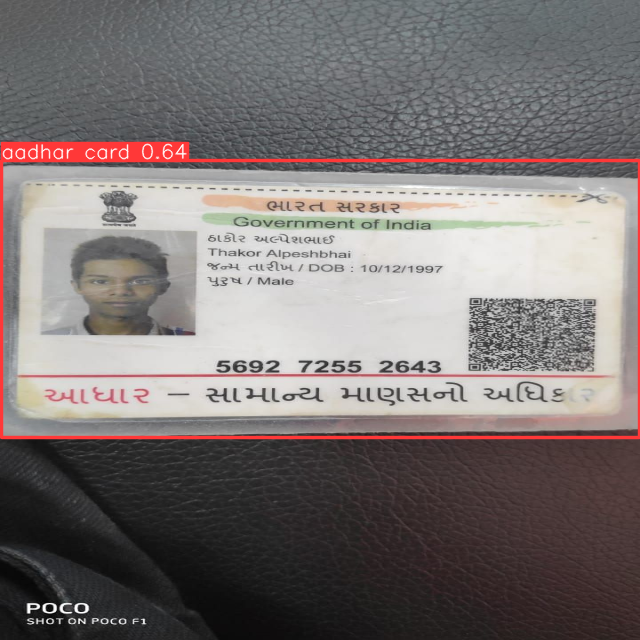

In [87]:
results = model(img)
results.show()

In [99]:
try:
    bbox = results.xyxy[0][0]
    cropped_image = get_cropped_image(img, bbox)
    detected_class = int(results.xyxy[0][0][-1])
    detected_class = names[detected_class]
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    result = ocr.ocr(cropped_image, cls=True)
    extraction = ""
    for idx in range(len(result)):
        res = result[idx]
        for line in res:
            extraction += line[-1][0]
            extraction += '\n'
    print(extraction)
    
except Exception as e:
    print("No document detected")

[2023/03/28 16:11:57] ppocr DEBUG: dt_boxes num : 9, elapse : 0.11600923538208008
[2023/03/28 16:11:57] ppocr DEBUG: cls num  : 9, elapse : 0.0882418155670166
[2023/03/28 16:11:59] ppocr DEBUG: rec_res num  : 9, elapse : 2.1661088466644287
Government of India
Thakor Alpeshbhai
/DOB10/12/1997
yt/Male
5692 7255 2643



In [100]:
result = ocr.ocr(cropped_image, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

[2023/03/28 16:11:59] ppocr DEBUG: dt_boxes num : 9, elapse : 0.12344050407409668
[2023/03/28 16:11:59] ppocr DEBUG: cls num  : 9, elapse : 0.09156441688537598
[2023/03/28 16:12:01] ppocr DEBUG: rec_res num  : 9, elapse : 2.224385976791382
[[[230.0, 53.0], [433.0, 57.0], [432.0, 73.0], [229.0, 69.0]], ('Government of India', 0.9438101053237915)]
[[[206.0, 86.0], [352.0, 88.0], [352.0, 101.0], [206.0, 99.0]], ('Thakor Alpeshbhai', 0.9551733732223511)]
[[[204.0, 99.0], [442.0, 102.0], [442.0, 115.0], [204.0, 112.0]], ('/DOB10/12/1997', 0.9484068751335144)]
[[[206.0, 113.0], [294.0, 115.0], [294.0, 128.0], [206.0, 127.0]], ('yt/Male', 0.7743744850158691)]
[[[215.0, 200.0], [441.0, 200.0], [441.0, 214.0], [215.0, 214.0]], ('5692 7255 2643', 0.9301264882087708)]


In [102]:
print(extraction)

Government of India
Thakor Alpeshbhai
/DOB10/12/1997
yt/Male
5692 7255 2643



In [135]:
def extract_aadhaar_info(extraction):
    
    # Define the sample string
    string = "Government of IndiaThakor Alpeshbhai/DOB10/12/1997yt/Male5692 7255 2643"

    # Define the regex pattern to extract the name, date of birth, gender, and the last sequence of numbers
    pattern = r"(?<=India)(\w+\s\w+)/DOB(\d{2}/\d{2}/\d{4})\w+/(\w+)(\d+ \d+ \d+)"

    # Use the search() method to extract the matched pattern from the string
    match = re.search(pattern, string)

    # Extract the matched groups
    name = match.group(1)
    dob = match.group(2)
    gender = match.group(3)
    numbers = match.group(4)
    
    return {
        "Name": name,
        "Date of birth": dob,
        "Gender": gender,
        "Numbers": numbers
    }

In [136]:
print(extract_aadhaar_info(extraction))

{'Name': 'Thakor Alpeshbhai', 'Date of birth': '10/12/1997', 'Gender': 'Male569', 'Numbers': '2 7255 2643'}
